### Data Visualization of the Capture24 Dataset

Objectives: 
1. Understand Distribution of HAC Labels
2. Understand Accelerometer Data ( 3-axis)
3. Understand Mapping between Accelerometer Data and HAC - how is this labelled?

### Labels Insights
There are several types of labels that were used to categorize HAC


| Label System               |  Granularity | Core Idea                                                                                                      | Typical Usage                                   |
| -------------------------- | :----------: | -------------------------------------------------------------------------------------------------------------- | ----------------------------------------------- |
| **`WillettsSpecific2018`** |   **High**   | Fine-grained behavior classes (e.g. walking, cycling, driving, mixed activity, sedentary still, sleep)         | detailed behavior recognition                   |
| **`WillettsMET2018`**      |    **Low**   | Same data but mapped to **MET intensity bins** (<1.5, 1.5–3, 3–6, >6 METs)                                     | energy expenditure / caloric intensity modeling |
| **`DohertySpecific2018`**  | **Med-High** | Explicit posture + locomotion categories (sitting, lying, standing, walking, cycling, running, vehicle travel) | biomechanical activity classification           |
| **`Willetts2018`**         |  **Medium**  | Coarse Willetts grouping (sleep, sedentary, light, MVPA)                                                       | population health behavior grouping             |
| **`Doherty2018`**          |  **Medium**  | Coarse Doherty grouping (sedentary, household/light, locomotion, sleep)                                        | epidemiology-friendly summary labels            |
| **`Walmsley2020`**         |  **Medium**  | Rationalized “modern” cross-cohort set (sleep, sedentary, walking, cycling, mixed MVPA, vehicle)               | standardized public-health comparisons          |


The "annotation-label-dictionary' provides a mapping between each of the label methods. For example, Willetts2018: Mixed  maps to Walmsley2020: light, etc.


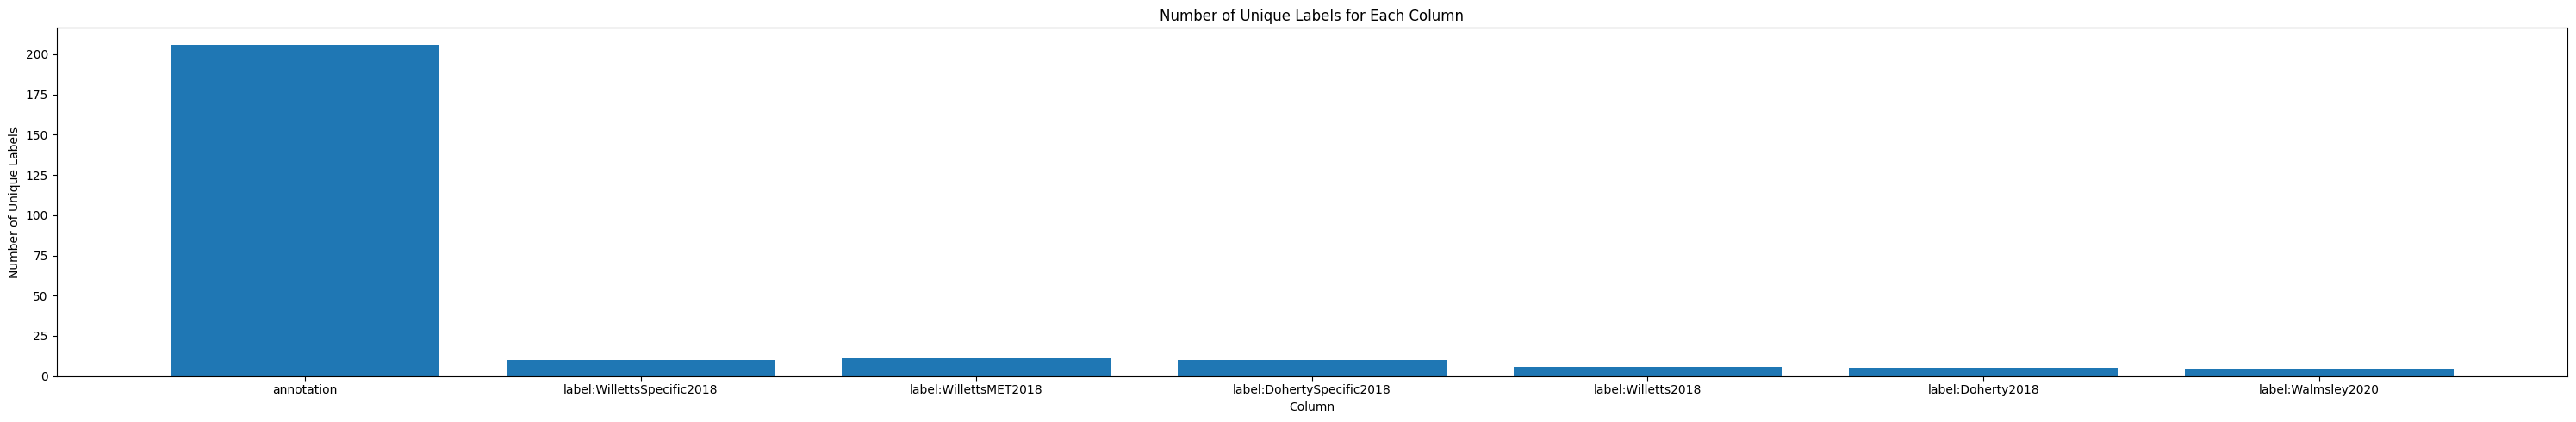

In [7]:
# Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

with open('capture24/data/capture24/annotation-label-dictionary.csv', 'r') as f:
    annotation_dict = pd.read_csv(f)

mapping = dict(zip(annotation_dict['annotation'], annotation_dict['label:Willetts2018']))

# Provide distribution of labels for each of these columsn
fig, axs = plt.subplots(figsize=(30, 5))

# simply plot the number of unique labels for each of these columns
axs.bar(annotation_dict.columns, annotation_dict.nunique())
axs.set_title('Number of Unique Labels for Each Column')
axs.set_xlabel('Column')
axs.set_ylabel('Number of Unique Labels')
plt.tight_layout()
plt.show()



In [ ]:
# Temp unzip p002
# !gzip -d capture24/P002.csv.gz

/var/folders/j5/9qw1sp3j5yvdfl0r334_ctw80000gn/T/ipykernel_77436/2543126664.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f)


Index(['time', 'x', 'y', 'z', 'annotation'], dtype='object')
['sleep' nan 'mixed' 'walking' 'vehicle' 'sit-stand']


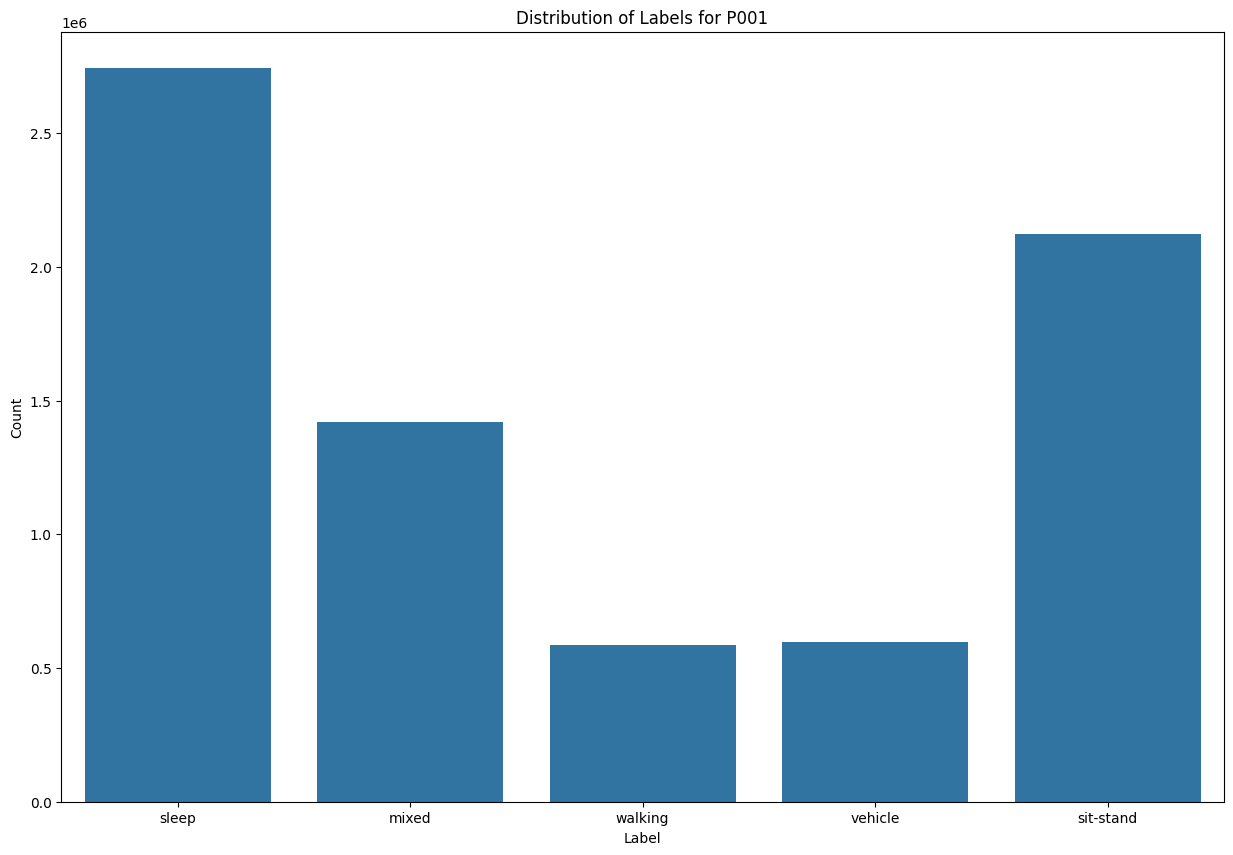

/var/folders/j5/9qw1sp3j5yvdfl0r334_ctw80000gn/T/ipykernel_77436/2543126664.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


In [14]:
# Get a sense of the individual time series data from the aceclerometer
with open('capture24/data/capture24/P001.csv', 'r') as f:
    data = pd.read_csv(f)

print(data.keys())

# from annotation -> Willetts2018
data['Willetts2018'] = data['annotation'].map(mapping)
print(data['Willetts2018'].unique())


# plot the label distribution 
fig, ax = plt.subplots(figsize= (15, 10))
sns.countplot(x='Willetts2018', data=data)
ax.set_title('Distribution of Labels for P001')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.show()

# plot the first 100 rows of the data - seperated by x,y,z and with time on the y
# fig, ax = plt.subplots(figsize= (25, 10))
# data_short = data.iloc[:10]

# # include legend
# sns.lineplot(x=range(len(data)), y=data['x'])
# sns.lineplot(x=range(len(data)), y=data['y'])
# sns.lineplot(x=range(len(data)), y=data['z'])
ax.legend()
plt.show()

### Preprcessing Steps
1. Define a Lookback, Patch, Slide Size
2. Process the input data in the context of this


#### PatchTST - benchmark configuration
Lookback: 96 [Options: 24, 48, 96, 192, 336, 720]
Patch: 64 [Options: 42, 64]

torch.tensor.unfold()
dimension (int) – dimension in which unfolding happens

size (int) – the size of each slice that is unfolded

step (int) – the step between each slice

In [ ]:
import torch
# Apply torch unfold to get the input to patches function

# current format -> pandas.DataFrame to [B, T, C] -> in this case [Batch, Time, Channel]
# remove labels from the data
input_data = data.drop(columns=['annotation'])

# quick santiy check

# combine x,y,z into a matrix
input_data_np = input_data[['x', 'y', 'z']].values
# Take the tail off in the case where the number of rows is not divisible by 32
# shape is [Time, Channel]
# trimmed_tail = input_data_np.shape[0] % 32
# print(trimmed_tail)
# input_data_np = input_data_np[:len(input_data_np)-trimmed_tail][:]
# print(input_data_np.shape)

# input_data_batched = np.array_split(input_data_np, 32)
# # Spli into 32 batches - concatenate them along the batch dimension
# input_data_torch = torch.tensor(input_data_batched[0]).unsqueeze(0)
# for batch in input_data_batched[1:]:
#     # convert to torch tensor 
#     batch_torch = torch.tensor(batch).unsqueeze(0)
#     input_data_torch = torch.cat((input_data_torch, batch_torch), dim=0)

# apply torch unfold
print(input_data_np.shape)
patches = torch.tensor(input_data_np).unsqueeze(0).unfold(dimension=1, size=10, step=10)
print(patches)


(10020001, 3)
tensor([[[[-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
          [-0.5333, -0.5333, -0.5333,  ..., -0.5489, -0.5333, -0.5489],
          [ 0.6585,  0.6585,  0.6585,  ...,  0.6585,  0.6585,  0.6585]],

         [[-0.4823, -0.4823, -0.4823,  ..., -0.4667, -0.4667, -0.4667],
          [-0.5489, -0.5489, -0.5333,  ..., -0.5489, -0.5333, -0.5333],
          [ 0.6585,  0.6585,  0.6585,  ...,  0.6585,  0.6585,  0.6585]],

         [[-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
          [-0.5333, -0.5489, -0.5333,  ..., -0.5333, -0.5333, -0.5333],
          [ 0.6585,  0.6585,  0.6585,  ...,  0.6585,  0.6585,  0.6585]],

         ...,

         [[ 0.0338,  0.0338,  0.0494,  ...,  0.0494,  0.0494,  0.0494],
          [-0.7823, -0.7823, -0.7823,  ..., -0.7978, -0.7823, -0.7823],
          [ 0.5657,  0.5657,  0.5657,  ...,  0.5657,  0.5657,  0.5811]],

         [[ 0.0494,  0.0494,  0.0494,  ...,  0.0494,  0.0494,  0.0494],
          [-0.7823, -0.7823

In [ ]:
print(patches.shape)

torch.Size([32, 31312, 3, 10])


In [ ]:
import numpy as np
file_path = 'capture24/prepared_data_512'
# Let's take a look at the prepared data
X_from_npy = np.load(f'{file_path}/X.npy')
print(X_from_npy[10])

# Let's take a look at the labels
Y_from_npy = np.load(f'{file_path}/Y_anno.npy', allow_pickle=True)
print(Y_from_npy[10])

Y_W2020 = np.load(f'{file_path}/Y_Walmsley2020.npy')
print(Y_W2020[10])

Y_Willetts2018 = np.load(f'{file_path}/Y_WillettsSpecific2018.npy')
print(Y_Willetts2018[10])

# Let's take a look at the time stamps
T_from_npy = np.load(f'{file_path}/T.npy')
print(T_from_npy[:10])

# Let's take a look at the patient ids
P_from_npy = np.load(f'{file_path}/P.npy')
# Process data to remove P and convert to int
P_from_npy = [int(i.split('P')[1]) for i in P_from_npy]

[[ 0.8251444  -0.2780502  -0.48983255]
 [ 0.8251444  -0.2780502  -0.48983255]
 [ 0.84065473 -0.2780502  -0.48983255]
 ...
 [ 0.8251444  -0.2780502  -0.48983255]
 [ 0.8251444  -0.2780502  -0.47412065]
 [ 0.8251444  -0.2780502  -0.48983255]]
7030 sleeping;MET 0.95
sleep
sleep
['2016-04-10T22:54:00.000000000' '2016-04-10T22:54:10.240000000'
 '2016-04-10T22:54:20.480000000' '2016-04-10T22:54:30.720000000'
 '2016-04-10T22:54:40.960000000' '2016-04-10T22:54:51.200000000'
 '2016-04-10T22:55:01.440000000' '2016-04-10T22:55:11.680000000'
 '2016-04-10T22:55:21.920000000' '2016-04-10T22:55:32.160000000']


In [5]:
# Create Training - Test Split
# Capture 24 specified split as the following:
# Participants 001 - 100 -> Training
# Participants (P)101 - 150 -> Test

# Easiest way to split is perhaps utilize a pandas dataframe for filtering
import pandas as pd

df = pd.DataFrame(
    {
        "Accelerometer_data": [x for x in X_from_npy],
        "Raw_Labels": Y_from_npy,
        "Walmsley2020_Labels": Y_W2020,
        "Willetts2018_Labels": Y_Willetts2018,
        "Time_Stamps": T_from_npy,
        "Patient_ID": P_from_npy
    }
)


# Split into training and test - save under capture24/final_data/
train_df = df[(df['Patient_ID'] <= 100)].reset_index(drop=True)
test_df = df[(df['Patient_ID'] > 100)].reset_index(drop=True)


In [6]:
import os
import json

# Create Index Mapping for the Labels
unique_labels = sorted(set(train_df['Willetts2018_Labels'].unique()))
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for label, index in label_to_index.items()}


# Encode the Labels - let's use the Willetts2018_Labels - in numpy format
Y_train = np.array(train_df['Willetts2018_Labels'])
Y_train_id = np.array([label_to_index[label] for label in Y_train])

# Encode the test labels in a similar manner
Y_test = np.array(test_df['Willetts2018_Labels'])
Y_test_id = np.array([label_to_index[label] for label in Y_test])

dir_path = 'capture24/final_data_512/'
os.makedirs(dir_path, exist_ok=True)
with open(f'{dir_path}/label_to_index.json', 'w') as f:
    json.dump({
        "label_to_index": label_to_index,
        "index_to_label": index_to_label
    }, f)


# Reshape the input data to be [B, T, C]
X_train = train_df["Accelerometer_data"].apply(
    lambda x: np.asarray(x, dtype=np.float32)
)

X_test = test_df["Accelerometer_data"].apply(
    lambda x: np.asarray(x, dtype=np.float32)
)


np.save(f'{dir_path}/X_train.npy', np.stack(X_train.values))
np.save(f'{dir_path}/X_test.npy', np.stack(X_test.values))

# Save the labels
np.save(f'{dir_path}/Y_train.npy', Y_train_id)
np.save(f'{dir_path}/Y_test.npy', Y_test_id)

['sleep' 'household-chores' 'walking' 'sitting' 'mixed-activity'
 'bicycling' 'standing' 'manual-work' 'sports' 'vehicle']


IndexError: index 9000 is out of bounds for axis 0 with size 5328

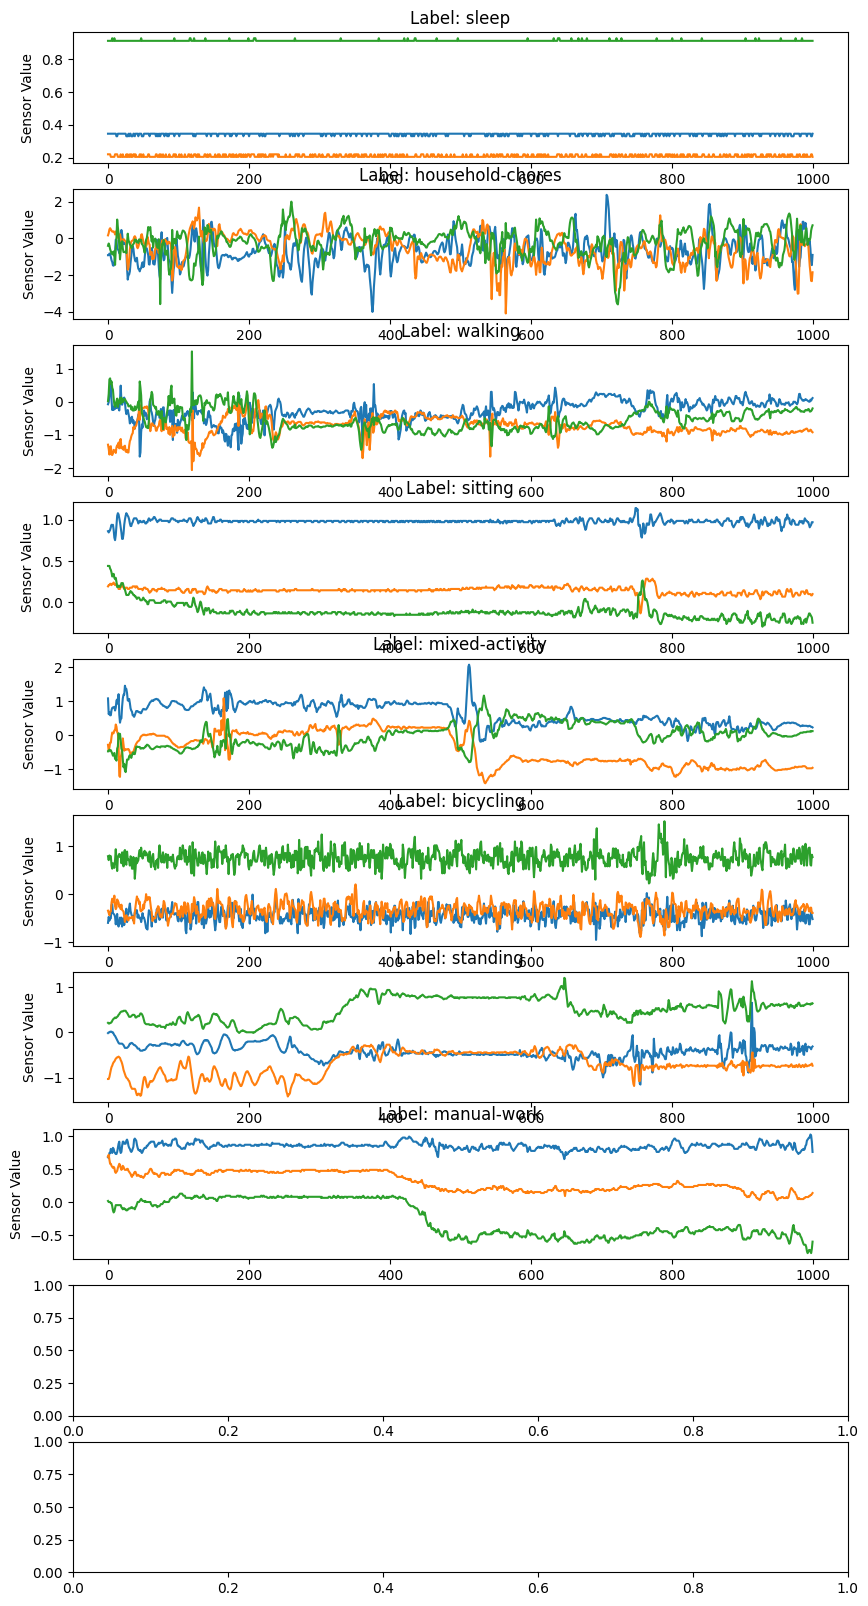

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
# Convert numpy array to pandas dataframe
Y_df = pd.DataFrame({"labels":Y_Willetts2018.reshape(-1)})
print(Y_df['labels'].unique())


unique_labels = Y_df['labels'].unique()
num_labels = len(unique_labels)

fig, axes = plt.subplots(num_labels, 1, figsize=(10, 2 * num_labels))
if num_labels == 1:
    axes = [axes]  # make iterable

for ax, label in zip(axes, unique_labels):
    idx = np.where(Y_df['labels'] == label)[0][9000]
    ax.plot(X_from_npy[idx])
    ax.set_title(f"Label: {label}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Sensor Value")

plt.tight_layout()
plt.show()
